Dataset Description
Variable Definition

id -> Unique ID for the customer
Gender ->Gender of the customer
Age ->Age of the customer
Driving_License ->0 : Customer does not have DL, 1 : Customer already has DL
Region_Code ->Unique code for the region of the customer
Previously_Insured ->1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
Vehicle_Age ->Age of the Vehicle
Vehicle_Damage ->1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
Annual_Premium ->The amount customer needs to pay as premium in the year
Policy_Sales_Channel ->Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
Vintage ->Number of Days, Customer has been associated with the company
Response ->1 : Customer is interested, 0 : Customer is not interested

In [3]:
import numpy as np 
import pandas as pd 
import skimpy 
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import friedmanchisquare
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from colorama import Style, Fore
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, TargetEncoder
import warnings
from sklearn.base import clone
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
import os
sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

warnings.simplefilter(action='ignore', category=FutureWarning)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# load data

In [5]:
train=pd.read_csv('/home/zhenghao/kaggle/test.csv', index_col='id')
test=pd.read_csv('/home/zhenghao/kaggle/train.csv',index_col='id')

In [6]:
train.head(3)
# 测试 是否正确读取训练集

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271


In [7]:
test.head(3)
# 测试 是否正确读取测试集

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0


In [8]:
print(f'{Style.BRIGHT}{Fore.YELLOW} SHAPE')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> train: {Fore.GREEN} {train.shape}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> test:  {Fore.GREEN} {test.shape}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} NULL VALUES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.isnull().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.isnull().any().any()}')

print(f'\n\n{Style.BRIGHT}{Fore.YELLOW} DUPLICATES')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Train: {Fore.GREEN} {train.duplicated().any().any()}')
print(f'{Style.BRIGHT}{Fore.YELLOW} -> Test:  {Fore.GREEN} {test.duplicated().any().any()}')


 SHAPE
 -> train:  (7669866, 10)
 -> test:   (11504798, 11)


 NULL VALUES
 -> Train:  False
 -> Test:   False


 DUPLICATES
 -> Train:  False
 -> Test:   False


用于检查训练和测试数据集的基本信息的：

数据形状：

打印训练和测试数据集的形状，查看行数和列数。
空值检查：

检查训练和测试数据集中是否存在任何空值。
重复值检查：

检查训练和测试数据集中是否存在任何重复值。

In [9]:
cat_cols = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']
#分类特征列
num_cols = ['Age', 'Region_Code','Annual_Premium','Vintage']
#数值特征列
target    = ['Response']
features = num_cols + cat_cols

for df in [train,test]:
    df[cat_cols] = df[cat_cols].astype('category')
#将cat_cols转换为category

In [10]:
skimpy.skim(train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types               Categories                                       │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                               │
│ ┃ dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                               │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                               │
│ │ Number of rows    │ 7669866 │ │ category    │ 5     │ │ Gender                │                               │
│ │ Number of columns │ 10      │ │ float64     │ 3     │ │ Driving_License       │                               │
│ └───────────────────┴─────────┘ │ int64       │ 2     │ │ Previously_Insured    │                               │
│                                 └─────────────┴───────┘ │ Vehicle_Age           │                               │
│                                                         │ Vehicle_Damage        │                               │
│                                                         └───────────────────────┘                               │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name             ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0    ┃ p25    ┃ p50   ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Age                     │   0 │     0 │  38.39 │     15 │    20 │     24 │    36 │    49 │     85 │ ▇▃▅▂▁  │  │
│ │ Region_Code             │   0 │     0 │  26.43 │  12.99 │     0 │     15 │    28 │    35 │     52 │ ▃▂▁▇▃▂ │  │
│ │ Annual_Premium          │   0 │     0 │  30470 │  16450 │  2630 │  25280 │ 31830 │ 39460 │ 540200 │   ▇    │  │
│ │ Policy_Sales_Channel    │   0 │     0 │  112.4 │  54.07 │     1 │     29 │   151 │   152 │    163 │ ▃   ▃▇ │  │
│ │ Vintage                 │   0 │     0 │  163.9 │  79.98 │    10 │     99 │   166 │   232 │    299 │ ▅▇▇▇▇▇ │  │
│ └─────────────────────────┴─────┴───────┴────────┴────────┴───────┴────────┴───────┴───────┴────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                                 ┃ NA      ┃ NA %         ┃ ordered            ┃ unique         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩  │
│ │ Gender                                      │       0 │            0 │ False              │              2 │  │
│ │ Driving_License                             │       0 │            0 │ False              │              2 │  │
│ │ Previously_Insured                          │       0 │            0 │ False              │              2 │  │
│ │ Vehicle_Age                                 │       0 │            0 │ False              │              3 │  │
│ │ Vehicle_Damage                              │       0 │            0 │ False              │              2 │  │
│ └─────────────────────────────────────────────┴─────────┴──────────────┴────────────────────┴────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [11]:
def plot_numerical():
    df = pd.concat([train[num_cols].assign(Source = 'Train'), 
                    test[num_cols].assign(Source = 'Test')], ignore_index = True)
    
    fig, axes = plt.subplots(len(num_cols), 3 ,figsize = (16, len(num_cols) * 4), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 
                                            'width_ratios': [0.80, 0.20, 0.20]})

    for i,col in enumerate(num_cols):
        ax = axes[i,0]
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
        ax.set_title(f"\n{col}",fontsize = 9)
        ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
        ax.set(xlabel = '', ylabel = '')

        ax = axes[i,1]
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title("Train", fontsize = 9)

        ax = axes[i,2]
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
        ax.set(xlabel = '', ylabel = '')
        ax.set_title("Test", fontsize = 9)

    plt.suptitle(f'\nDistribution analysis - numerical features',fontsize = 12, y = 0.95, x = 0.57, fontweight='bold')
    plt.show()

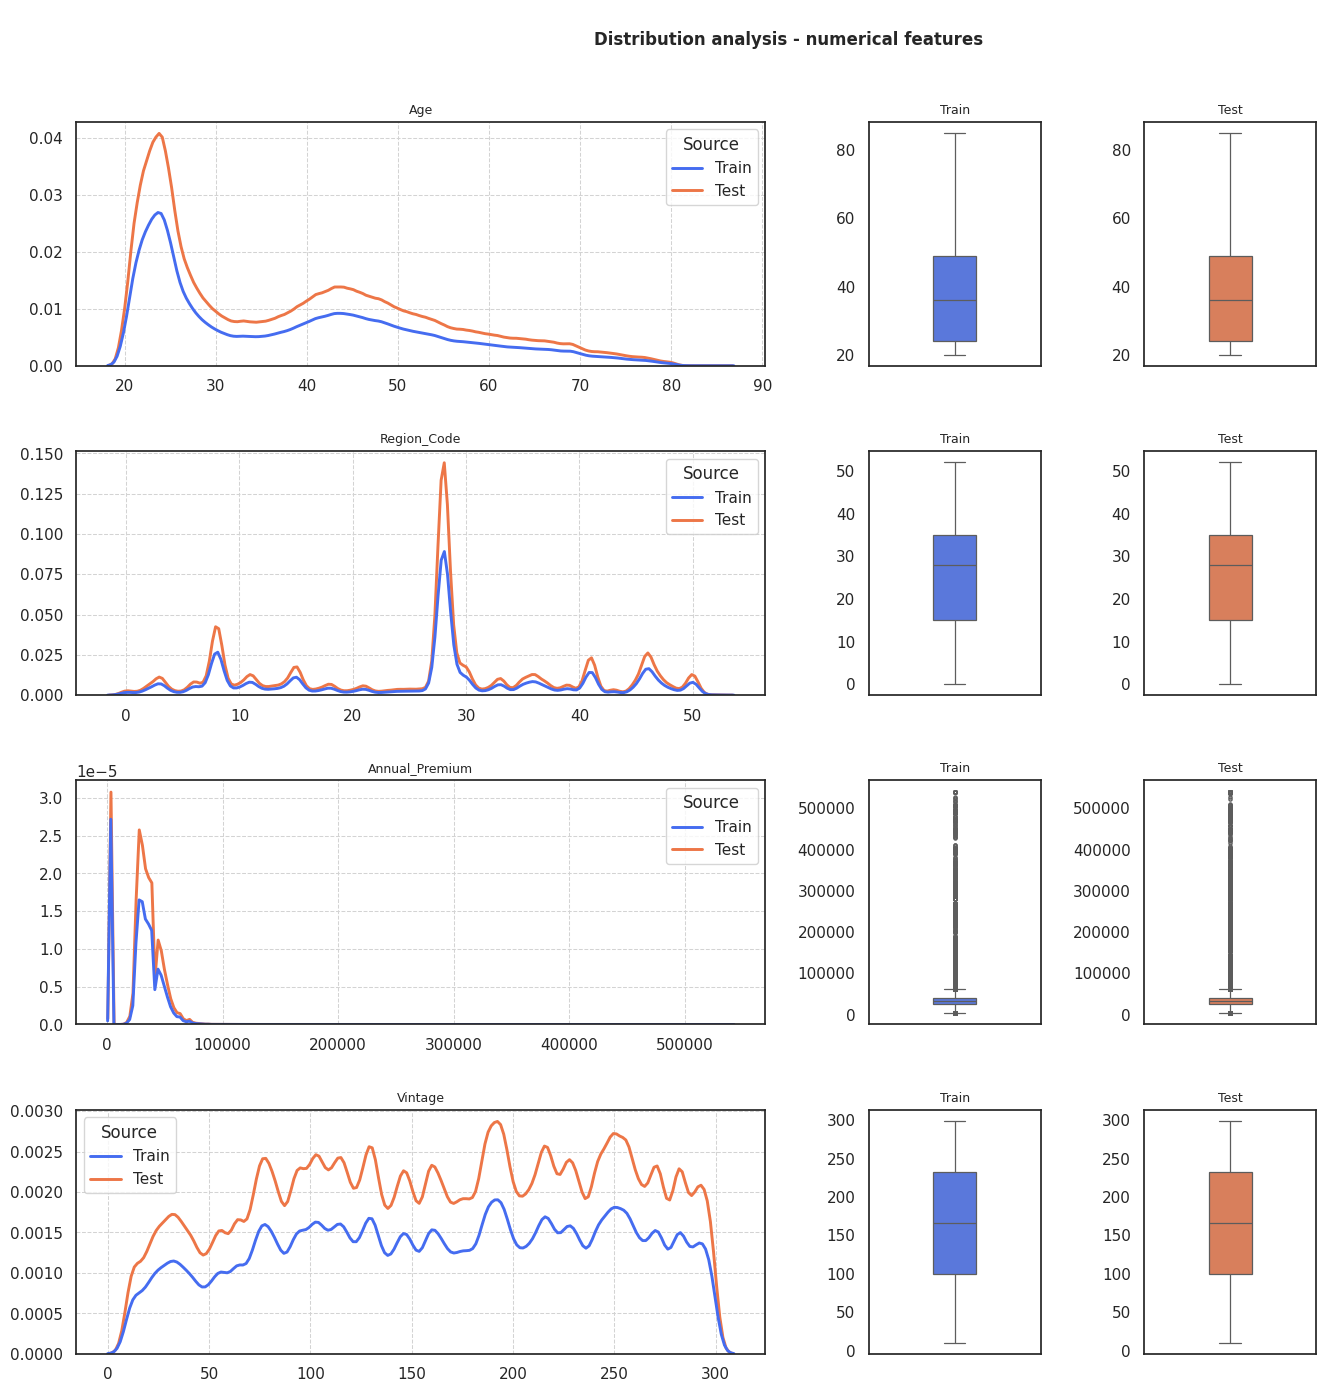

In [12]:
plot_numerical()

In [13]:
def plot_cat(limit_unique=20):
    selectcols = train[cat_cols].nunique()<=limit_unique
    cols_ = selectcols[selectcols].index.to_list()
    n_cols = len(cols_)
    fig, ax = plt.subplots(n_cols, 2, figsize=(12, 4 * n_cols))
    for i, coluna in enumerate(cols_):    
        sns.countplot(x=train[coluna], ax=ax[i, 0])
        ax[i, 0].set_title(f'{coluna}')
        ax[i, 0].set_ylabel('Count')
        ax[i, 0].set_xlabel(coluna)
        ax[i, 0].tick_params(axis='x', labelrotation=45)

        for container in ax[i, 0].containers:
            ax[i, 0].bar_label(container, fmt='%d', label_type='center', rotation=90)
            

        s1 = train[coluna].value_counts()        

        textprops = {
            'size':8, 
            'weight': 'bold', 
            'color':'white'
        }

        ax[i, 1].pie(s1,
            autopct='%2.2f%%',
            pctdistance=0.8, 
            textprops=textprops,
            labels=train[coluna].value_counts().index
        )    
        ax[i, 1].set_title(f'% {coluna}')

    plt.tight_layout()
    plt.show()

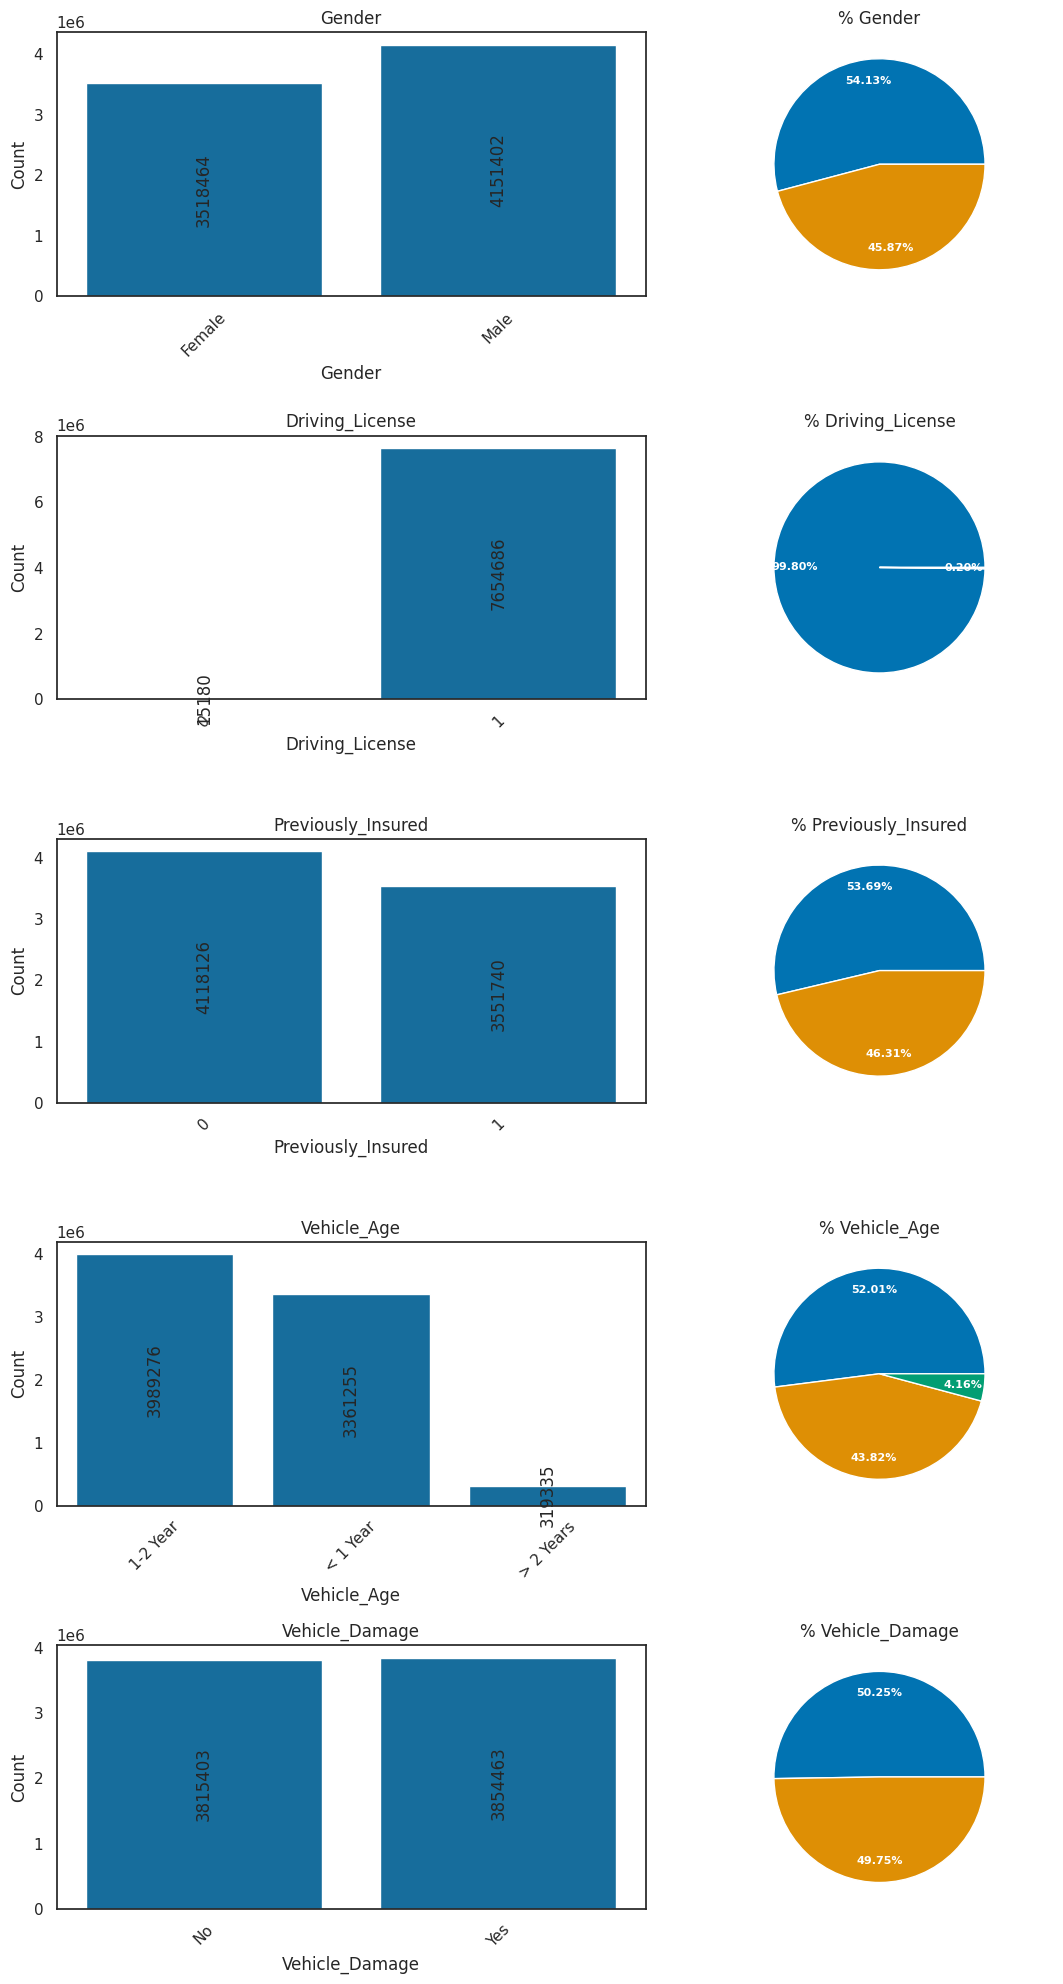

CPU times: user 30.4 s, sys: 9.16 s, total: 39.5 s
Wall time: 39.2 s


In [14]:
%%time
plot_cat()

In [16]:
def crossvalidate(estimator, label = ''):
    
    X = train.copy()
    y = X.pop('Response')
    
    oof_ = np.zeros((len(X)))
    train_scores, val_scores = [], []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        
        train_preds = model.predict_proba(X_train)[:, 1]
        val_preds = model.predict_proba(X_val)[:, 1]
                  
        oof_[val_idx] += val_preds
                
        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)
        
        print(f'Fold {fold+1}: {val_score:.5f}')

        train_scores.append(train_score)
        val_scores.append(val_score)
    
    print(f'{Style.BRIGHT}{Fore.BLUE}Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}{Style.RESET_ALL}')
    
    return val_scores, oof_

In [17]:
%%time
score['logisticRegression'], oof['logisticRegression'] = crossvalidate(make_pipeline(OneHotEncoder(cat_cols),
                                                                                   StandardScaler(),
                                                                                   LogisticRegression(max_iter=1000)),'LogisticRegression')

KeyError: 'Response'